#Non-Linear Time History Analysis (NLTHA) in Single Degree of Freedom (SDOF) Oscillators

In this method, a single degree of freedom (SDOF) model of each structure under analysis is subjected to a series of ground motion records through a non-linear time history analysis (NLTHA). The displacements of the SDOF due to each ground motion record are used as input to determine the distribution of buildings in each damage state for each level of ground motion. A regression algorithm is then applied to derive the fragility model. This fragility method is suitable to test building portfolios against a set of ground motion records.

The following figure presents a fragility model developed using this method. 

<img src="../../../../figures/NLTHA_SDOF.png" width="400" align="middle">

##Load capacity curves

In order to use this methodology, it is necessary to provide one (or a group) of capacity curves, defined according to the format established on the [RMTK manual](../../../../../rmtk-docs.pdf). Please provide the location of the file containing this input using the parameter `capacity_curves_file`.

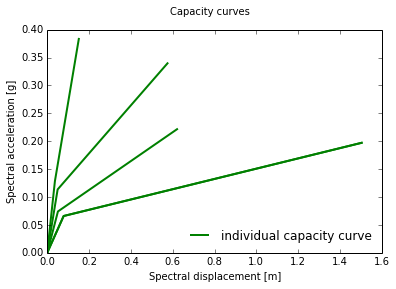

{'Say': [0.12821, 0.074098, 0.11358, 0.065933], 'periods': [1.52, 1.63], 'Sa': [[0.0, 0.12821, 0.29829, 0.31955, 0.3833], [0.0, 0.074098, 0.17239, 0.18468, 0.22154], [0.0, 0.11358, 0.26426, 0.28309, 0.3396], [0.0, 0.065933, 0.1534, 0.16433, 0.19713]], 'Sd': [[0.0, 0.036802, 0.11298, 0.1225, 0.15107], [0.0, 0.051318, 0.43086, 0.4783, 0.62062], [0.0, 0.049906, 0.39992, 0.44367, 0.57493], [0.0, 0.078588, 1.028, 1.1467, 1.5027]], 'type': 'Sd-Sa', 'Sdy': [0.036802, 0.051318, 0.049906, 0.078588], 'gamma': [1.24, 1.24], 'heights': []}


In [1]:
from rmtk.vulnerability.common import utils
%matplotlib inline 

capacity_curves_file = '../../../../../rmtk_data/capacity_curves_sdof.csv'
capacity_curves = utils.read_capacity_curves(capacity_curves_file)
utils.plot_capacity_curves(capacity_curves)
print capacity_curves

## Load ground motion records

The demand in this methodology is input by a set of ground motion records, which should follow the format established in the [RMTK manual](../../../../../rmtk-docs.pdf). Please provide the location of this folder using the parameter gmrs_folder. It is also possible to plot the corresponding response spectra (displacement, pseudo-acceleration, and Sa-Sd), for which the minimum and maximum periods of interest (minT and maxT) should also be provided.

In [2]:
gmrs_folder = '../../../../../rmtk_data/recs_trial'
gmrs = utils.read_gmrs(gmrs_folder)
minT = 0.1
maxT = 2
#utils.plot_response_spectra(gmrs,minT,maxT)

##Calculate fragility function

In order to obtain the fragility model, it is necessary to input the location of the damage model (`damage_model`), using the format described in the [RMTK manual](../../../../../rmtk-docs.pdf). It is as well necessary to input the damping value of the structure(s) under analysis and the value of the period (T) to be considered in the regression analysis. The method allows to consider or not degradation. Finally, if desired, it is possible to save the resulting fragility model in a .csv file. 


25%
[0.036802, 0.06536900000000001, 0.093936, 0.15107]
50%
[0.051318, 0.1936435, 0.33596899999999996, 0.62062]
75%
[0.049906, 0.18116200000000002, 0.31241800000000003, 0.57493]
100%
[0.078588, 0.434616, 0.790644, 1.5027]


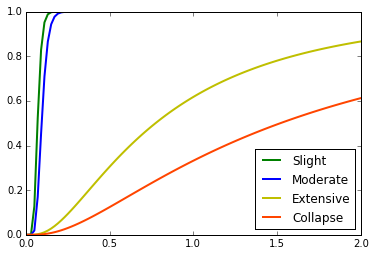

IOError: [Errno 2] No such file or directory: '../../../../../../rmtk_data/output/fragility_output.csv'

In [10]:
import NLTHA_on_SDOF

damage_model = utils.read_damage_model('../../../../../rmtk_data/damage_model.csv')
damping = 0.05
T = 2.0
degradation = False
regression_method = 'least squares'
save = True
output_type = 'logmean-cov'
PDM, Sds = NLTHA_on_SDOF.calculate_fragility(capacity_curves,gmrs,damage_model,damping,degradation)
fragility_model = utils.calculate_mean_fragility(gmrs,PDM,T,damping,'Sa',damage_model,regression_method)
utils.plot_fragility_model(fragility_model,0.01,2)
utils.create_fragility_out_files(fragility_model,save,output_type)